In [1]:
from __future__ import division
import pandas as pd
import pandas_datareader as pdr
import numpy as np
from numpy.linalg import inv,pinv
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
matplotlib.style.use('ggplot')

from performance import *

# Purpose of the Notebook

Factor Risk Parity Prototype

In [2]:
country_etfs = pd.read_csv('../Data/country_data/ETF_adj_close.csv',index_col=0)
country_etfs.index = pd.to_datetime(country_etfs.index)
ff5 = pdr.famafrench.FamaFrenchReader('Emerging_5_Factors',start = '2000-01-01').read()[0]
ff_mom = pdr.famafrench.FamaFrenchReader('Emerging_MOM_Factor',start = '2000-01-01').read()[0]
ff6 = pd.concat([ff5,ff_mom],axis=1)

In [3]:
# find weekly return - take last date and pct-change
country_returns = country_etfs.resample('W').last().pct_change()
# country_returns.index = country_returns.index.to_period('W')

In [4]:
equity_factors = pd.read_pickle('../Outputs/equity/equity_country_factors_rf.pkl')

equity_factors = equity_factors[equity_factors.momentum.notnull()]

# Step 1: Obtain Loading and Covariance Matrix per Cluster

In [5]:
# weeks = pd.Series(pd.period_range(start='2000-01-01', end='2020-12-31', freq='W')).rename('Week').reset_index()
# weeks['Date'] = pd.to_datetime(weeks['Week'].dt.strftime('%Y-%m'))
# weeks['Date'] = weeks['Date'].dt.to_period('M')

# ff6_monthly = ff6.copy()
# # reindex to weekly
# ff6 = ff6.reset_index().merge(weeks).set_index('Week')
# _ = ff6.pop('index')

In [6]:
rolling_betas = {}
# ff5_new = ff5.copy()
# ff5_new['Mkt'] = ff5_new['Mkt-RF'] + ff5_new['RF']
#cols = ['SMB', 'HML', 'RMW', 'CMA', 'Mkt']
factors= ['size', 'value', 'momentum', 'low_beta']

for c in country_returns:
    y = country_returns.loc[equity_factors.index][c]
    y = y*100-equity_factors['market-rf'] - equity_factors['rf']
    y = y.dropna()
    X = equity_factors.loc[y.index][factors]
    X = sm.add_constant(X, prepend=False)
    mod = RollingOLS(y, X,window=52)
    rolling_res = mod.fit(params_only = True)
    rolling_betas[c] = rolling_res.params
rolling_df = pd.concat(rolling_betas)

In [7]:
weeks_list = rolling_df.index.get_level_values(1).unique()

weekly_exposure, weekly_cov = {}, {}
factor_rolling_cov = equity_factors[factors].rolling(52, min_periods = 1).cov()
for m in weeks_list:
    week_df = rolling_df.loc[(slice(None), m), :].iloc[:,:-1]
    weekly_exposure[m] = week_df
    weekly_cov[m] = factor_rolling_cov.loc[(m,slice(None)), :]

In [8]:
# risk budgeting optimization
def calculate_portfolio_var(w,V):
    # function that calculates portfolio risk
    w = np.matrix(w)
    return (w*V*w.T)[0,0]

def calculate_risk_contribution(w,V):
    # function that calculates asset contribution to total risk
    w = np.matrix(w)
    sigma = np.sqrt(calculate_portfolio_var(w,V))
    # Marginal Risk Contribution
    MRC = V*w.T
    # Risk Contribution
    RC = np.multiply(MRC,w.T)/sigma
    return RC

def risk_budget_objective(x,pars):
    # calculate portfolio risk
    V = pars[0]# covariance table
    x_t = pars[1] # risk target in percent of portfolio risk
    sig_p =  np.sqrt(calculate_portfolio_var(x,V)) # portfolio sigma
    risk_target = np.asmatrix(np.multiply(sig_p,x_t))
    asset_RC = calculate_risk_contribution(x,V)
    J = sum(np.square(asset_RC-risk_target.T))[0,0] # sum of squared error
#     print(J)
    return J

def total_weight_constraint(x):
    return np.sum(x)-1.0

In [9]:
x_t = [0.25, 0.25, 0.25, 0.25] # risk budget percent of total portfolio risk (equal risk)
cons = ({'type': 'eq', 'fun': total_weight_constraint})
w0 = [0.25,0.25,0.25,0.25]


# weekly
# periods = pd.period_range(start='2015-09-27', end='2021-01-31', freq='W')
container = {}
for m in weekly_cov.keys():
    V = weekly_cov[m].values * 100
    if not np.any(np.isnan(V)):
        res= minimize(risk_budget_objective, w0, args=[V,x_t], method='SLSQP',constraints=cons)
        w = np.asmatrix(res.x)
        weights = weekly_exposure[m].values * w.T
        if not np.all(np.isnan(weights)):
            weight_df = pd.DataFrame(weights,index = weekly_exposure[m].index,columns = ['Weights']).droplevel(1,axis=0)
            container[m] = weight_df

<AxesSubplot:xlabel='level_0'>

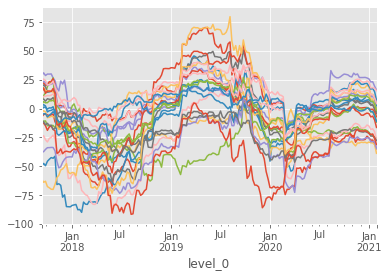

In [27]:
# unnormalized weights
rp_raw = pd.concat(container).reset_index().pivot(columns = 'level_1',index = 'level_0')
rp_raw.plot(legend = False)

In [12]:
rp_raw = rp_raw.div(rp_raw.sum(axis=1), axis=0)
country_rp = country_returns.loc[rp_raw.index].values * rp_raw.values
country_rp = pd.DataFrame(country_rp.sum(axis=1),columns = ['risk_parity'], index = rp_raw.index)

<AxesSubplot:xlabel='level_0'>

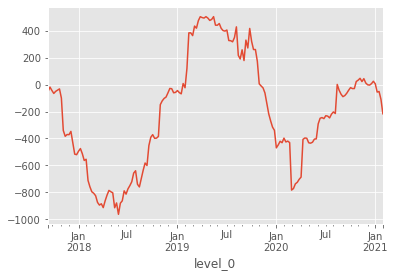

In [35]:
rp_raw.sum(axis=1).plot()

In [40]:
country_ew = country_returns.loc[rp_raw.index].mean(axis=1)
country_ew = pd.DataFrame(country_ew,columns = ['equal_weighted'], index = rp_raw.index)

## Performance

In [41]:
portfolios = country_rp.join(country_ew)

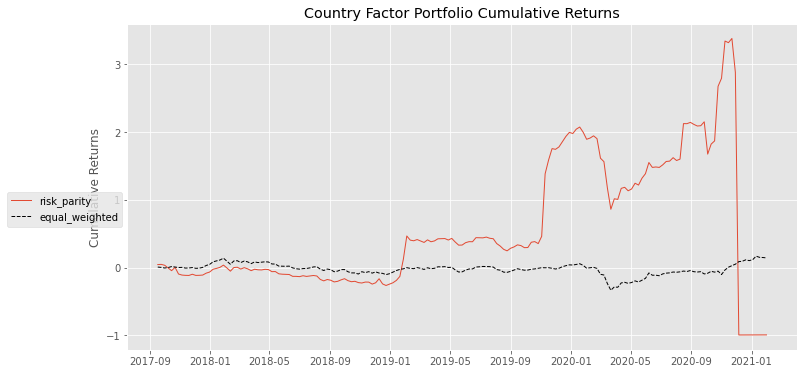

In [46]:
all_port_cum_ret_df = calc_cum_returns(portfolios)

# Plot cumulative returns
plot_perf(perf=[all_port_cum_ret_df[x] for x in list(all_port_cum_ret_df.columns.values)[:-1]], \
          perf_bm=all_port_cum_ret_df['equal_weighted_cum_ret'], label=country_rp.columns, \
          title='Country Factor Portfolio Cumulative Returns',benchmark_label='equal_weighted')